## Upload netcdf data to database

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from datetime import datetime
from datetime import timedelta
from fabric import Connection
import psycopg2
import pandas.io.sql as sqlio
import getpass
from io import StringIO
import paramiko
import sys
from time import sleep
import xarray as xr
from joblib import Parallel,delayed
import glob

sys.path.insert(0, "/home/jovyan/watexr/PROGNOS/")
from prognos_tools.gce_light import gce_api as gce

key = getpass.getpass('mobiserver password: ')
vaultKey = getpass.getpass('vault password: ')
#Querying necessary tokens
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result


cloudKey = json.loads(query('''select niva.getToken('gce_access','{}');'''.format(vaultKey)).iloc[0,0])
sshKey = query('''select niva.getToken('geonorway_ssh_key','{}');'''.format(vaultKey)).iloc[0,0]
not_really_a_file = StringIO(sshKey)
geo_key = paramiko.RSAKey.from_private_key(not_really_a_file)

del key,sshKey,vaultKey

mobiserver password:  ·······
vault password:  ···············


## Starting instance with database

In [2]:
#Check status of instance

#Properties of the instance containing the database
geo_props = {'project'      : 'nivacatchment',
             'zone'         : 'europe-north1-a',
             'instanceName' : "dtm10",
             'username'     : "jose-luis",
             }

#Setting up credential for google cloud
cloud = gce(geo_props, cloudKey)


#Getting instance info
cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
info = cloud.get('custom')
display(info['status'])
#If instance is stopped, start it
if info['status'] != 'RUNNING':
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}/start'''
    info = cloud.post('custom')
    display(info['status'])
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
    info = cloud.get('custom')
    while info['status'] != 'RUNNING':
           sleep(2)
           info = cloud.get('custom')
        
del cloudKey        
   
geo_ip = info['networkInterfaces'][0]['accessConfigs'][0]['natIP']    
display(geo_ip)
geo_config =  {'host' : geo_ip, 'user': 'jose-luis', 'connect_kwargs': {'pkey': geo_key } }

#Function to query the database
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host=geo_ip, port=5432, database='geonorway') as db:
        with db.cursor() as cursor :
            cursor.execute(query)
            if fetch:
                result = sqlio.read_sql_query(query, db)
                return result

'RUNNING'

'35.228.213.48'

## Putting data in database as bytea

The script assumes that the netcdf era5 files have been downloaded to the database (use getERAData.ipynb notebook).
The following script will be uploaded to the vm containing the database and should be run there.

In [82]:
%%writefile uploadDirBytea.py
#! /usr/bin/python3
#Script to upload netcdf file to database as bytea. The script expects one argument:
#the name of the folder where the netcdf files are

import sys
from fabric import Connection
import glob
import psycopg2
import xarray as xr
from psycopg2.extras import execute_values
from joblib import Parallel,delayed
from tqdm import tqdm

#The script should upload all files inside a folder to a database. It is assumed that all files in the folder
#have the same spatial extent
folder=sys.argv[1]
print(folder)
fileList = glob.glob('{}/*.nc'.format(folder))
print(fileList)

#We will use the first file in the folder to set up the database

data = xr.load_dataset(fileList[0])
pev=data['pev']
time=data['time']
longitude=data['longitude']
latitude=data['latitude']
shp = pev.shape
print(data.keys())
data.close()

#name of the schema where the data will be placed
schema = 'era5'

#Helper function to upload data using psycopg2
def query(query,fetch=False):
    with psycopg2.connect(user='jose-luis', host='localhost', port=5432, database='geonorway') as db:
        cursor = db.cursor()
        cursor.execute(query)
        if fetch:
            return cursor.fetchall()

sql = '''drop schema if exists {schema} cascade;

create schema {schema};

create table {schema}.latitude(cid int unique primary key,latitude double precision unique);

create table {schema}.longitude(rid int unique primary key,longitude double precision unique);

create table {schema}.time(tid serial unique primary key, fecha timestamptz unique);

create table {schema}.location(sid serial unique primary key,
idx int unique,
row int references {schema}.longitude(rid), 
col int references {schema}.latitude(cid), 
geom geography(polygon,4326),
point geometry(point,4326),
unique(row,col));


create table {schema}.attributes (aid serial unique primary key, name varchar(20), unit varchar(20), longname varchar(100));

create table {schema}.encoding (eid serial unique primary key,novalue smallint, scalefactor double precision, addoffset double precision);

create table {schema}.variables(tid int references {schema}.time(tid) not null, 
aid int references {schema}.attributes(aid) not null,
eid int references {schema}.encoding(eid) not null,
val bytea, unique (tid,aid));

ALTER TABLE {schema}.variables ALTER COLUMN val SET STORAGE EXTERNAL;

create index {schema}_attrs_name_idx on {schema}.attributes(name);

create index {schema}_location_idx_idx on {schema}.location(idx);

create index {schema}_time_fecha_idx on {schema}.time(fecha);

create index {schema}_variables_tid_idx on {schema}.variables(tid);
create index {schema}_variables_aid_idx on {schema}.variables(aid);
create index {schema}_variables_eid_idx on {schema}.variables(eid);
create index {schema}_variables_tid_aid_idx on {schema}.variables(tid,aid);

'''
query(sql.format(schema=schema))

with psycopg2.connect(user='jose-luis', host='localhost', port=5432, database='geonorway') as db:
    cursor = db.cursor()
    execute_values(cursor,'''insert into {schema}.longitude(rid,longitude) values %s;'''.format(schema=schema),
                   [(i,float(j)) for i,j in zip(range(longitude.size),longitude.values)])
    execute_values(cursor,'''insert into {schema}.latitude(cid,latitude) values %s;'''.format(schema=schema),
                   [(i,float(j)) for i,j in zip(range(latitude.size),latitude.values)])
    execute_values(cursor,'''insert into {schema}.location(idx,row,col) values %s;'''.format(schema=schema),
                   [(i,i%pev.shape[2],i//pev.shape[2]) for i in range(pev.shape[1] *  pev.shape[2])])

    
with psycopg2.connect(user='jose-luis', host='localhost', port=5432, database='geonorway') as db:
    cursor = db.cursor()   
    for i in data.keys():
        attrs = data[i].attrs
        cursor.execute('''insert into {schema}.attributes (name,unit,longname) values ('{}','{}','{}');'''.format(i,attrs['units'],attrs['long_name'],schema=schema))

sql = '''
update {schema}.location as a
set geom = st_makeEnvelope(longitude - 0.125,
latitude - .125,
longitude + .125,
latitude + .125,
4326)
from {schema}.longitude as b, {schema}.latitude as c
where b.rid = a.row  and c.cid = a.col;

update {schema}.location as a
set point = st_setsrid(st_makePoint(cast(longitude as double precision)/100,
cast(latitude as double precision)/100),4326)
from {schema}.longitude as b, {schema}.latitude as c
where b.rid = a.row  and c.cid = a.col;

create index {schema}_location_point_idx on {schema}.location using gist(point);
create index {schema}_location_geom_idx on {schema}.location using gist(geom);

'''.format(schema=schema)

query(sql)

sql='''CREATE OR REPLACE FUNCTION {schema}.bytea_to_raw(b bytea)
    RETURNS smallint[]
    LANGUAGE 'plpython3u'
AS $BODY$
  if 'struct' in GD:
    struct = GD['struct']
  else:
    import struct
    GD['struct'] = struct

  return struct.unpack('<' + str(int(len(b) / 2)) + 'h', b)
$BODY$;
'''  

query(sql.format(schema=schema))


sql='''CREATE OR REPLACE FUNCTION {schema}.bytea_to_double_array(
    b bytea,
    scalefactor double precision,
    addoffset double precision
)
    RETURNS double precision[]
    LANGUAGE 'plpython3u'
    COST 100
    VOLATILE PARALLEL UNSAFE
AS $BODY$
if 'struct' in GD:
    struct = GD['struct']
else:
    import struct
    GD['struct'] = struct

return [i*scalefactor + addoffset for i in struct.unpack('<' + str(int(len(b) / 2)) + 'h', b)]
$BODY$;'''

query(sql.format(schema=schema))


sql='''create or replace view era5.unpack as 
select a.tid, a.aid, {schema}.bytea_to_double_array(a.val,b.scalefactor,b.addoffset) as val
from {schema}.variables as a
join {schema}.encoding as b
on a.eid=b.eid;
'''

query(sql.format(schema=schema))


with psycopg2.connect(user='jose-luis', host='localhost', port=5432, database='geonorway') as db:
    cursor = db.cursor()
    cursor.execute('''select name,aid from {schema}.attributes'''.format(schema=schema))
    aid = cursor.fetchall()    

aidDict = {}
for i in aid:
    aidDict[i[0]] = i[1]
    
print(aidDict)    
    
def arrayCnt(x,y):
    while True:
        for i in range(x*y):
            yield i
def repTime(t,x,y):
    while True:
        for i in t:
            for j in range(x*y):
                yield i
                

#Creating directory for unpacking netcdf data
with Connection('localhost') as c:
    c.local('''rm -rf unpacked_{schema} && mkdir unpacked_{schema}'''.format(schema=schema))
    

def insertFile(path):
    data = xr.load_dataset(path)
    time=data['time']
    sql = '''insert into {schema}.time (fecha) values {values} returning tid;'''.format(schema=schema,values='(' + '),('.join(["'{}-00'".format(i) for i in time.values])  +')')
    a = [i[0] for i in query(sql,fetch=True)]
    #Unpacking netcdf data
#     with Connection('localhost') as c:
#         c.local('''ncpdq -U -o unpacked_{schema}/{} {path}'''.format(path.split('/')[-1],schema=schema,path=path))

    for key in data.keys():
        currentEncoding = data[key].encoding
        eid = query('''insert into {schema}.encoding (novalue,scalefactor,addoffset) values {values} returning eid;'''.format(schema=schema,values='({missing_value},{scale_factor},{add_offset})'.format(**currentEncoding)),fetch=True)
        eid = eid[0][0]
                    
        for i,tid in enumerate(a):
            with Connection('localhost') as c:
                c.local('''ncks -O -o unpacked_{schema}/bla_{key}_{tid}.nc -C -b unpacked_{schema}/val_{key}_{tid}.bin -d time,{i} -v {key} {path} '''.format(path =path,
                                                                                                                                           schema=schema,
                                                                                                                                           i=i,
                                                                                                                                           tid=tid,
                                                                                                                                           key=key))
            with psycopg2.connect(user='jose-luis', host='localhost', port=5432, database='geonorway') as db:
                cursor = db.cursor()
                cursor.execute('''insert into {schema}.variables (tid,aid,eid,val) values({tid},{aid},{eid},pg_read_binary_file('/home/jose-luis/unpacked_{schema}/val_{key}_{tid}.bin'))'''.format(
                    tid=tid,eid=eid,schema=schema,key=key,aid=aidDict[key]))
            with Connection('localhost') as c:
                c.local('''rm unpacked_{schema}/bla_{key}_{tid}.nc unpacked_{schema}/val_{key}_{tid}.bin'''.format(tid=tid,schema=schema,key=key))
#     with Connection('localhost') as c:
#         c.local('''rm unpacked_{schema}/{} {path}'''.format(path.split('/')[-1],schema=schema,path=path))
    data.close()
            
    
Parallel(n_jobs=4)(delayed(insertFile)(i) for i in tqdm(fileList))

Overwriting uploadDirBytea.py


In [83]:
#Putting scrip in vm containing the database
with Connection(**geo_config) as c:
    c.put('uploadDirBytea.py')
    c.run('chmod +x uploadDirBytea.py')
    
#IMPORTANT: the script should now be run in the vm containing the database

CPU times: user 61.5 ms, sys: 3.07 ms, total: 64.6 ms
Wall time: 104 ms


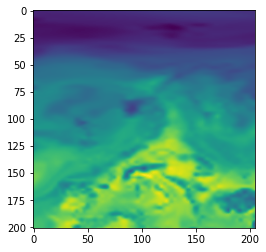

In [115]:
%%time
#Getting data from the database
a = query('''select * from era5.variables as a join era5.encoding as b on a.eid=b.eid where aid=7 order by tid asc limit 1;''')
shape = query('''select (select count(*) from era5.longitude) as cols, (select count(b.*) from era5.latitude as b) as rows;''')
numvals = shape.apply(np.prod, axis=1)[0]
data = struct.unpack('<{}h'.format(numvals), a.loc[0][3])
offset = a.loc[0][-1]
scale = a.loc[0][-2]
novalue= a.loc[0][-3]
data = [scale * i + offset if i!= novalue else 0 for i in data]
data = np.asarray(data).reshape(201,205,order='C')

plt.imshow(data)
# display(query('''select * from era5.unpack limit 3;'''))

In [110]:
data

array([[-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10],
       [-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10],
       [-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10],
       ...,
       [-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10],
       [-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10],
       [-3.49245965e-10, -3.49245965e-10, -3.49245965e-10, ...,
        -3.49245965e-10, -3.49245965e-10, -3.49245965e-10]])

In [99]:
display(query('''select * from era5.attributes;'''))

,aid,name,unit,longname
0,1,u10,m s**-1,10 metre U wind component
1,2,v10,m s**-1,10 metre V wind component
2,3,d2m,K,2 metre dewpoint temperature
3,4,t2m,K,2 metre temperature
4,5,cdir,J m**-2,Clear-sky direct solar radiation at surface
5,6,msl,Pa,Mean sea level pressure
6,7,msdwlwrfcs,W m**-2,Mean surface downward long-wave radiation flux...
7,8,msdwswrfcs,W m**-2,Mean surface downward short-wave radiation flu...
8,9,pev,m,Potential evaporation
9,10,tcc,(0 - 1),Total cloud cover
